## Transfer Learning with TensorFlow - Part 2

In [1]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from helper_function import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### 1. Data preparation

In [2]:
train_dir_path_10_10 = "image_data/10_food_classes_10_percent/train/"
test_dir_path_10_10 = "image_data/10_food_classes_10_percent/test/"
train_dir_path_10_1 = "image_data/10_food_classes_1_percent/train/"
test_dir_path_10_1 = "image_data/10_food_classes_1_percent/test/"

In [3]:
### Walk thro image data path

walk_through_dir("image_data/10_food_classes_10_percent")

There are 2 directories and 0 images in 'image_data/10_food_classes_10_percent'.
There are 10 directories and 0 images in 'image_data/10_food_classes_10_percent\test'.
There are 0 directories and 250 images in 'image_data/10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in 'image_data/10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in 'image_data/10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in 'image_data/10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in 'image_data/10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in 'image_data/10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in 'image_data/10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in 'image_data/10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in 

In [4]:
img_size = (224, 224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir_path_10_10,
    image_size = img_size, label_mode = "categorical", batch_size = 32)

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir_path_10_10,
    image_size = img_size, label_mode = "categorical")

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir_path_10_1,
    image_size = img_size, label_mode = "categorical", batch_size = 32)

test_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir_path_10_1,
    image_size = img_size, label_mode = "categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.
Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [5]:
### Check its type and shape

train_data_10_percent

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [6]:
### Check class names

train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [7]:
### Review anexample batch of data

for images, labels in train_data_10_percent.take(1):
    print(images, labels)

tf.Tensor(
[[[[ 88.87245    79.69898    77.28571  ]
   [ 83.88265    75.88265    72.88265  ]
   [ 87.86224    80.505104   78.29082  ]
   ...
   [138.78578    39.08164    13.647972 ]
   [149.801      46.5408     17.678513 ]
   [153.95937    49.31651    16.602156 ]]

  [[ 91.908165   86.831635   82.85715  ]
   [ 92.081635   87.081635   83.081635 ]
   [ 93.015305   88.015305   85.015305 ]
   ...
   [124.4694     72.000015   50.770424 ]
   [129.86734    74.36734    48.010178 ]
   [132.43379    74.959305   47.693996 ]]

  [[ 91.57653    89.0051     84.21938  ]
   [ 93.         90.42857    85.64286  ]
   [ 92.02041    88.52551    85.35714  ]
   ...
   [138.70923   113.4286    101.37754  ]
   [139.5867    111.87243    98.31627  ]
   [134.56628   107.78057    90.066284 ]]

  ...

  [[174.42859    22.7858     14.285823 ]
   [175.07143    21.214373   13.000109 ]
   [178.38263    24.357208   15.8062   ]
   ...
   [ 98.142944   14.          9.214264 ]
   [100.285706   11.255091    5.270398 ]
   [1

### 2. Model building
First model (EfficientNetV2B0) - Transfer learning (feature extraction) on 10% of 10 classes food data

In [8]:
### Set include_top = False because we have custom input layer
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top = False)

### Freeze to keep pre-learned pattern
base_model.trainable = False

### Create input layer
input_layer = tf.keras.layers.Input(shape = (224, 224, 3), name = "input_layer")

x = base_model(input_layer)
# print(x.shape)

x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
# print(x.shape)

### Create output layer
output_layer = tf.keras.layers.Dense(10, activation = "softmax", name = "output_layer")(x)

### Combine the input layer and output layer into single model
first_model = tf.keras.Model(input_layer, output_layer)

### Compiling the model
first_model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"])

first_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
__________________

In [9]:
### Check EfficientNetV2B0 summary

base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

 block3b_expand_activation   (None, None, None, 192)      0         ['block3b_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block3b_project_conv (Conv  (None, None, None, 48)       9216      ['block3b_expand_activation[0]
 2D)                                                                [0]']                         
                                                                                                  
 block3b_project_bn (BatchN  (None, None, None, 48)       192       ['block3b_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block3b_drop (Dropout)      (None, None, None, 48)       0         ['block3b_project_bn[0][0]']  
          

 2D)                                                                                              
                                                                                                  
 block4b_project_bn (BatchN  (None, None, None, 96)       384       ['block4b_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block4b_drop (Dropout)      (None, None, None, 96)       0         ['block4b_project_bn[0][0]']  
                                                                                                  
 block4b_add (Add)           (None, None, None, 96)       0         ['block4b_drop[0][0]',        
                                                                     'block4a_project_bn[0][0]']  
                                                                                                  
 block4c_e

 block5a_project_conv (Conv  (None, None, None, 112)      64512     ['block5a_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block5a_project_bn (BatchN  (None, None, None, 112)      448       ['block5a_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block5b_expand_conv (Conv2  (None, None, None, 672)      75264     ['block5a_project_bn[0][0]']  
 D)                                                                                               
                                                                                                  
 block5b_expand_bn (BatchNo  (None, None, None, 672)      2688      ['block5b_expand_conv[0][0]'] 
 rmalizati

 ormalization)                                                                                    
                                                                                                  
 block5c_drop (Dropout)      (None, None, None, 112)      0         ['block5c_project_bn[0][0]']  
                                                                                                  
 block5c_add (Add)           (None, None, None, 112)      0         ['block5c_drop[0][0]',        
                                                                     'block5b_add[0][0]']         
                                                                                                  
 block5d_expand_conv (Conv2  (None, None, None, 672)      75264     ['block5c_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block5d_e

 block5e_project_bn (BatchN  (None, None, None, 112)      448       ['block5e_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block5e_drop (Dropout)      (None, None, None, 112)      0         ['block5e_project_bn[0][0]']  
                                                                                                  
 block5e_add (Add)           (None, None, None, 112)      0         ['block5e_drop[0][0]',        
                                                                     'block5d_add[0][0]']         
                                                                                                  
 block6a_expand_conv (Conv2  (None, None, None, 672)      75264     ['block5e_add[0][0]']         
 D)                                                                                               
          

                                                                                                  
 block6b_add (Add)           (None, None, None, 192)      0         ['block6b_drop[0][0]',        
                                                                     'block6a_project_bn[0][0]']  
                                                                                                  
 block6c_expand_conv (Conv2  (None, None, None, 1152)     221184    ['block6b_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block6c_expand_bn (BatchNo  (None, None, None, 1152)     4608      ['block6c_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block6c_e

 block6d_drop (Dropout)      (None, None, None, 192)      0         ['block6d_project_bn[0][0]']  
                                                                                                  
 block6d_add (Add)           (None, None, None, 192)      0         ['block6d_drop[0][0]',        
                                                                     'block6c_add[0][0]']         
                                                                                                  
 block6e_expand_conv (Conv2  (None, None, None, 1152)     221184    ['block6d_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block6e_expand_bn (BatchNo  (None, None, None, 1152)     4608      ['block6e_expand_conv[0][0]'] 
 rmalization)                                                                                     
          

                                                                                                  
 block6f_drop (Dropout)      (None, None, None, 192)      0         ['block6f_project_bn[0][0]']  
                                                                                                  
 block6f_add (Add)           (None, None, None, 192)      0         ['block6f_drop[0][0]',        
                                                                     'block6e_add[0][0]']         
                                                                                                  
 block6g_expand_conv (Conv2  (None, None, None, 1152)     221184    ['block6f_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block6g_expand_bn (BatchNo  (None, None, None, 1152)     4608      ['block6g_expand_conv[0][0]'] 
 rmalizati

 ormalization)                                                                                    
                                                                                                  
 block6h_drop (Dropout)      (None, None, None, 192)      0         ['block6h_project_bn[0][0]']  
                                                                                                  
 block6h_add (Add)           (None, None, None, 192)      0         ['block6h_drop[0][0]',        
                                                                     'block6g_add[0][0]']         
                                                                                                  
 top_conv (Conv2D)           (None, None, None, 1280)     245760    ['block6h_add[0][0]']         
                                                                                                  
 top_bn (BatchNormalization  (None, None, None, 1280)     5120      ['top_conv[0][0]']            
 )        

In [10]:
### Check how many layer of EfficientNetV2B0 vs first model layer

len(base_model.layers), len(first_model.layers)

(270, 4)

In [11]:
### View more detailed layer in EfficientNetV2B0

for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 block

In [12]:
### Set 25 percent of less of the validation data so faster epochs

first_model_history = first_model.fit(train_data_10_percent, epochs = 5, steps_per_epoch = len(train_data_10_percent), 
    validation_data = test_data_10_percent, validation_steps = int(0.25 * len(test_data_10_percent)),
    callbacks = [create_tensorboard_callback("model_log", "10_percent_feature_extraction")])

Saving TensorBoard log files to: model_log/10_percent_feature_extraction/20230926-004119
Epoch 1/5
24/24 [==============================] - 35s 1s/step - loss: 1.9183 - accuracy: 0.3800 - val_loss: 1.3246 - val_accuracy: 0.7303
Epoch 2/5
24/24 [==============================] - 28s 1s/step - loss: 1.1673 - accuracy: 0.7347 - val_loss: 0.8973 - val_accuracy: 0.8092
Epoch 3/5
24/24 [==============================] - 28s 1s/step - loss: 0.8640 - accuracy: 0.8147 - val_loss: 0.7066 - val_accuracy: 0.8520
Epoch 4/5
24/24 [==============================] - 28s 1s/step - loss: 0.7054 - accuracy: 0.8440 - val_loss: 0.5982 - val_accuracy: 0.8569
Epoch 5/5
24/24 [==============================] - 28s 1s/step - loss: 0.6066 - accuracy: 0.8587 - val_loss: 0.5398 - val_accuracy: 0.8684


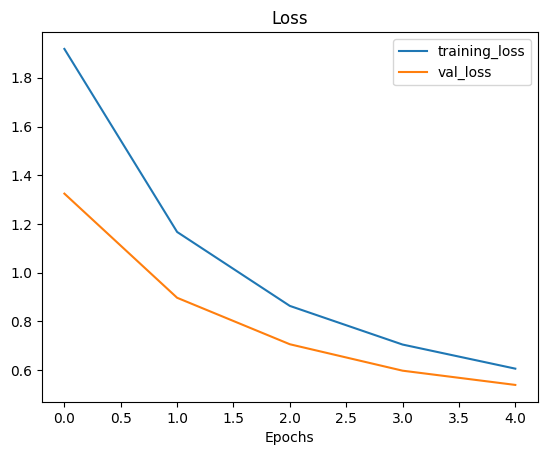

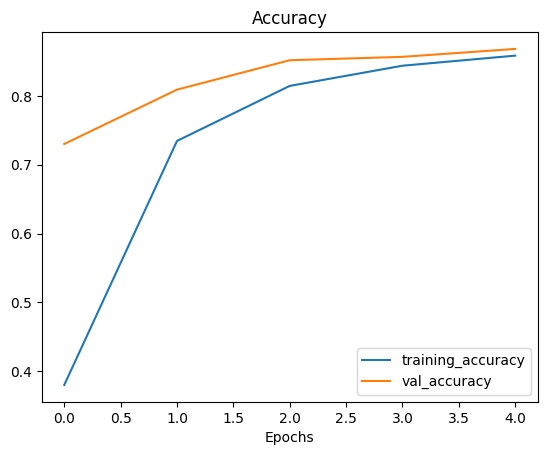

In [13]:
### Check first model's training curves

plot_loss_curves(first_model_history)

Model 2 - Transfer learning (feature extraction) on 1% of the data with data augmentation

In [14]:
### Create data augmentation function

data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
], name = "data_augmentation")

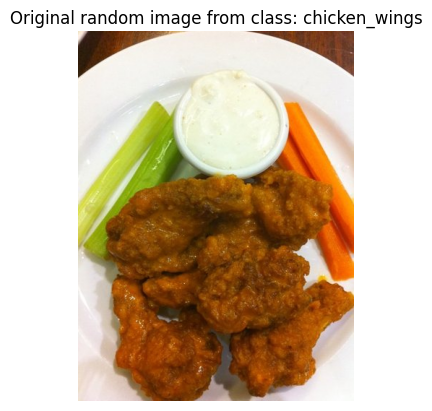

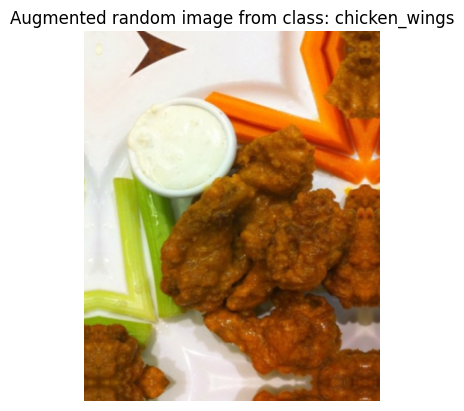

In [15]:
### View original image vs augmented image

random_target_class = random.choice(train_data_1_percent.class_names)
target_dir = "image_data/10_food_classes_1_percent/train/" + random_target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

org_img = mpimg.imread(random_image_path)

plt.imshow(org_img)
plt.title(f"Original random image from class: {random_target_class}")
plt.axis(False);

augmented_img = data_augmentation(tf.expand_dims(org_img, axis = 0))

plt.figure()
plt.imshow(tf.squeeze(augmented_img) / 255.)
plt.title(f"Augmented random image from class: {random_target_class}")
plt.axis(False);

In [16]:
### Second model design

input_shape = (224, 224, 3)

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top = False)
base_model.trainable = False

input_layer = layers.Input(shape = input_shape, name = "input_layer")

x = data_augmentation(input_layer)

###  Don't train it during augmentation
x = base_model(x, training = False)

x = layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)

output_layer = layers.Dense(10, activation = "softmax", name = "output_layer")(x)

second_model = keras.Model(input_layer, output_layer)

second_model.compile(loss = "categorical_crossentropy", optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"])

second_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [17]:
second_model_history = second_model.fit(train_data_1_percent, epochs = 5, steps_per_epoch = len(train_data_1_percent),
    validation_data = test_data_1_percent, validation_steps = int(0.25 * len(test_data_1_percent)),
    callbacks = [create_tensorboard_callback("model_log", "1_percent_data_augmentation_feature_extraction")])

Saving TensorBoard log files to: model_log/1_percent_data_augmentation_feature_extraction/20230926-004350
Epoch 1/5
3/3 [==============================] - 22s 7s/step - loss: 2.5094 - accuracy: 0.0714 - val_loss: 2.3609 - val_accuracy: 0.1217
Epoch 2/5
3/3 [==============================] - 16s 7s/step - loss: 2.2550 - accuracy: 0.2000 - val_loss: 2.2470 - val_accuracy: 0.1776
Epoch 3/5
3/3 [==============================] - 17s 8s/step - loss: 2.0881 - accuracy: 0.2857 - val_loss: 2.1440 - val_accuracy: 0.2368
Epoch 4/5
3/3 [==============================] - 17s 8s/step - loss: 1.9789 - accuracy: 0.3714 - val_loss: 2.0564 - val_accuracy: 0.3092
Epoch 5/5
3/3 [==============================] - 17s 8s/step - loss: 1.8044 - accuracy: 0.5143 - val_loss: 1.9561 - val_accuracy: 0.3536


In [18]:
### Evaluation of testing data

second_model.evaluate(test_data_1_percent)

79/79 [==============================] - 59s 746ms/step - loss: 1.9732 - accuracy: 0.3276


[1.9731765985488892, 0.32760000228881836]

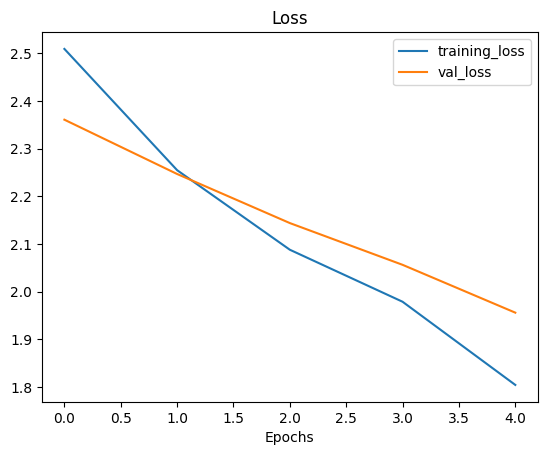

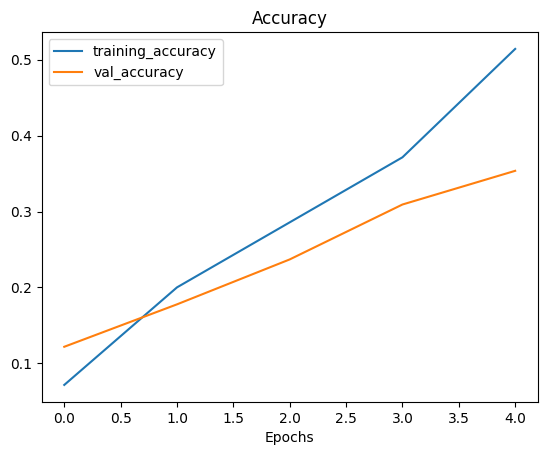

In [19]:
### Plotting of data augmentation layer with only 1% of data

plot_loss_curves(second_model_history)

Model 3 - Transfer learning (feature extraction) on 10% of the data with data augmentation

In [21]:
third_model = tf.keras.models.clone_model(second_model)
third_model.compile(loss = "categorical_crossentropy", optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"])

third_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281